In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
class UNet(nn.Module):
    def contracting_block(self,in_channels,out_channels,kernel_size = 3):
        block = nn.Sequential(
        nn.Conv2d(kernel_size=kernel_size,in_channels=in_channels,out_channels=out_channels,),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(kernel_size=kernel_size,in_channels=out_channels,out_channels=out_channels),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels))
        return block
    
    def expansive_block(self,in_channels,mid_channel,out_channels,kernel_size=3):
        block = nn.Sequential(
        nn.Conv2d(kernel_size=kernel_size,in_channels=in_channels,out_channels=mid_channel),
        nn.ReLU(),
        nn.BatchNorm2d(mid_channel),
        nn.Conv2d(kernel_size=kernel_size,in_channels=mid_channel,out_channels=mid_channel),
        nn.ReLU(),
        nn.BatchNorm2d(mid_channel),
        nn.ConvTranspose2d(in_channels=mid_channel,out_channels=out_channels,kernel_size=3,stride=2,padding=1,output_padding=1))
        return block
    
    def final_block(self,in_channels,mid_channel,out_channels,kernel_size=3):
        block = nn.Sequential(
        nn.Conv2d(kernel_size=kernel_size,in_channels=in_channels,out_channels=mid_channel),
        nn.ReLU(),
        nn.BatchNorm2d(mid_channel),
        nn.Conv2d(kernel_size=kernel_size,in_channels=mid_channel,out_channels=mid_channel),
        nn.ReLU(),
        nn.BatchNorm2d(mid_channel),
        nn.Conv2d(kernel_size=kernel_size,in_channels=mid_channel,out_channels=out_channels),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels))
        return block
    
    def __init__(self,in_channel,out_channel):
        super(UNet,self).__init__()
        # Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel,out_channels=64)
        self.conv_maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64,128)
        self.conv_maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128,256)
        self.conv_maxpool3 = nn.MaxPool2d(kernel_size=2)
        # Bottle-Neck
        self.bottleneck = nn.Sequential(
        nn.Conv2d(kernel_size=3,in_channels=256,out_channels=512),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.Conv2d(kernel_size=3,in_channels=512,out_channels=512),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=3,stride=2,padding=1,output_padding=1))
        # Decode
        self.decode3 = self.expansive_block(in_channels=512,mid_channel=256,out_channels=128)
        self.decode2 = self.expansive_block(in_channels=256,mid_channel=128,out_channels=64)
        self.final_layer = self.final_block(in_channels=128,mid_channel=64,out_channels=out_channel)
    
    def crop_and_concat(self,upsampled,bypass,crop = False):
        if crop:
            c = ((bypass.size()[2]) - upsampled.size()[2]) // 2
            bypass = F.pad(bypass,(-c,-c,-c,-c))
        return torch.cat((upsampled,bypass),1)
    
    def forward(self,x):
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        bottleneck1 = self.bottleneck(encode_pool3)
        decode_block3 = self.crop_and_concat(upsampled=bottleneck1,bypass=encode_block3,crop=True)
        cat_layer2 = self.decode3(decode_block3)
        decode_block2 = self.crop_and_concat(upsampled=cat_layer2,bypass=encode_block2,crop=True)
        cat_layer1 = self.decode2(decode_block2)
        decode_block1 = self.crop_and_concat(upsampled=cat_layer1,bypass=encode_block1,crop=True)
        final_layer = self.final_layer(decode_block1)
        return final_layer

In [5]:
net = UNet(in_channel=3,out_channel=2)

In [6]:
print(net)

UNet(
  (conv_encode1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_encode2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_encode3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), st

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('water_coins.jpg')
print(img.shape)

(312, 252, 3)


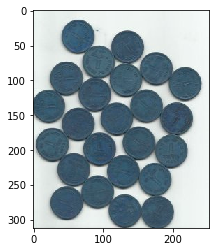

In [8]:
%matplotlib inline
plt.imshow(img)

In [9]:
device = torch.device('cuda:0')
print(device)

cuda:0


In [10]:
img1 = torch.from_numpy(img)
print(img1.shape)

torch.Size([312, 252, 3])


In [11]:
img2 = img1.view(3,312,252)
img2.shape

torch.Size([3, 312, 252])

In [12]:
out = net(img2)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3 3 3, but got 3-dimensional input of size [3, 312, 252] instead

In [13]:
img = cv2.resize(img,(572,572))
print(img.shape)
img1 = torch.from_numpy(img)
img2 = img1.view(3,572,572)
img2.shape

(572, 572, 3)


torch.Size([3, 572, 572])

In [14]:
img2 = img2.view(-1,3,572,572).type(torch.FloatTensor)
print(img2.shape)
out = net(img2)

torch.Size([1, 3, 572, 572])


In [15]:
net.eval()
out = net(img2)

In [16]:
out

tensor([[[[-0.0238, -0.0238, -0.0238,  ..., -0.0238, -0.0181, -0.0238],
          [-0.0238, -0.0172, -0.0238,  ..., -0.0238, -0.0238, -0.0238],
          [-0.0238, -0.0238, -0.0238,  ..., -0.0238, -0.0238, -0.0238],
          ...,
          [ 0.0168,  0.0201,  0.0078,  ..., -0.0238, -0.0238, -0.0238],
          [-0.0238, -0.0238, -0.0238,  ...,  0.0945,  0.0840,  0.0452],
          [ 0.1189,  0.1274,  0.0988,  ...,  0.0093, -0.0238,  0.0873]],

         [[-0.0222, -0.0222, -0.0222,  ..., -0.0222, -0.0222, -0.0222],
          [-0.0222, -0.0222, -0.0222,  ..., -0.0222, -0.0222, -0.0222],
          [-0.0203, -0.0222, -0.0222,  ..., -0.0222, -0.0222, -0.0222],
          ...,
          [-0.0222, -0.0222, -0.0222,  ..., -0.0222, -0.0222, -0.0222],
          [-0.0153, -0.0060, -0.0222,  ..., -0.0222, -0.0222, -0.0222],
          [ 0.0188,  0.0916,  0.0379,  ...,  0.0333,  0.0571,  0.0574]]]],
       grad_fn=<NativeBatchNormBackward>)

In [17]:
net.train()
out = net(img2)

In [18]:
out

tensor([[[[-0.1554,  1.5470,  0.8178,  ..., -0.7275, -0.7275, -0.7275],
          [-0.4909,  0.1008, -0.7275,  ..., -0.7275, -0.7275, -0.7275],
          [-0.2665, -0.7275, -0.3878,  ...,  1.0330, -0.7275,  1.7133],
          ...,
          [ 0.7458,  0.8094, -0.1887,  ...,  0.4765, -0.7275, -0.6304],
          [-0.6010, -0.4872, -0.7275,  ...,  1.8176,  1.6124,  1.4606],
          [ 4.8479,  0.7352,  0.7842,  ..., -0.7275, -0.7275, -0.7275]],

         [[-0.6315, -0.6315, -0.6315,  ..., -0.6315, -0.6315, -0.6315],
          [-0.6315, -0.6315, -0.6315,  ...,  1.1066,  0.5785,  1.1361],
          [ 1.1893,  2.5278,  0.3489,  ..., -0.0947, -0.6315, -0.6315],
          ...,
          [-0.0593, -0.6315, -0.6315,  ..., -0.6315, -0.5846,  0.2554],
          [-0.6315, -0.6315, -0.6315,  ..., -0.0470,  0.1610, -0.3508],
          [-0.6315,  3.2800,  0.1159,  ..., -0.2983,  1.3542, -0.4405]]]],
       grad_fn=<NativeBatchNormBackward>)

In [19]:
print(out.shape)

torch.Size([1, 2, 482, 482])


In [20]:
net.eval()
out = net(img2)
print(out.shape)

torch.Size([1, 2, 482, 482])


In [21]:
out[0]

tensor([[[-0.0474, -0.0474, -0.0474,  ..., -0.0474, -0.0474, -0.0474],
         [-0.0474, -0.0474, -0.0474,  ..., -0.0474, -0.0474, -0.0474],
         [-0.0474, -0.0474, -0.0474,  ..., -0.0474, -0.0474, -0.0474],
         ...,
         [ 0.0035, -0.0187, -0.0204,  ..., -0.0474, -0.0474, -0.0474],
         [-0.0474, -0.0474, -0.0474,  ...,  0.0437,  0.0370,  0.0118],
         [ 0.0678,  0.0705,  0.0325,  ..., -0.0442, -0.0474,  0.0327]],

        [[-0.0442, -0.0442, -0.0442,  ..., -0.0442, -0.0442, -0.0442],
         [-0.0442, -0.0442, -0.0442,  ..., -0.0442, -0.0442, -0.0442],
         [-0.0365, -0.0442, -0.0442,  ..., -0.0442, -0.0442, -0.0442],
         ...,
         [-0.0442, -0.0442, -0.0442,  ..., -0.0442, -0.0442, -0.0442],
         [-0.0312, -0.0222, -0.0442,  ..., -0.0442, -0.0442, -0.0442],
         [ 0.0033,  0.0819,  0.0315,  ...,  0.0034,  0.0221,  0.0301]]],
       grad_fn=<SelectBackward>)

In [22]:
out[0][0]

tensor([[-0.0474, -0.0474, -0.0474,  ..., -0.0474, -0.0474, -0.0474],
        [-0.0474, -0.0474, -0.0474,  ..., -0.0474, -0.0474, -0.0474],
        [-0.0474, -0.0474, -0.0474,  ..., -0.0474, -0.0474, -0.0474],
        ...,
        [ 0.0035, -0.0187, -0.0204,  ..., -0.0474, -0.0474, -0.0474],
        [-0.0474, -0.0474, -0.0474,  ...,  0.0437,  0.0370,  0.0118],
        [ 0.0678,  0.0705,  0.0325,  ..., -0.0442, -0.0474,  0.0327]],
       grad_fn=<SelectBackward>)

In [23]:
out1 = out.view(482,482,2)

In [24]:
out1.shape

torch.Size([482, 482, 2])

In [27]:
out1[0,0,:]

tensor([-0.0474, -0.0474], grad_fn=<SliceBackward>)